<a href="https://colab.research.google.com/github/Neloxe/nlp-project/blob/main/RNN-Glove-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

# 1. CHARGEMENT DES DONNÉES
data = pd.read_csv('./train.csv')
texts = data['comment_text'].astype(str).values
labels = data.iloc[:, 2:].values  # Colonnes de toxicité
label_names = data.columns[2:]  # Noms des classes

In [4]:
# 2. TOKENISATION ET VECTORISATION
max_words = 20000  # Vocabulaire max
max_len = 100  # Longueur max des séquences
embedding_dim = 100  # Taille des embeddings

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

In [5]:
# 3. CHARGEMENT DES EMBEDDINGS PRÉ-ENTRAÎNÉS (ex: GloVe)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

embeddings_index = {}
with open('/content/drive/MyDrive/glove.6B.100d.txt', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vectors

# Création de la matrice d'embedding
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        vector = embeddings_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

Mounted at /content/drive


In [6]:
# 4. SPLIT DES DONNÉES
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# 5. CONSTRUCTION DU MODÈLE
model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='sigmoid')  # 6 classes multi-label (toxic, severe_toxic, obscene, etc.)
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      21,033,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,033,900 (80.24 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,033,900 (80.24 MB)

In [7]:
# 6. ENTRAÎNEMENT DU MODÈLE
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 62s 26ms/step - accuracy: 0.7638 - loss: 0.1098 - val_accuracy: 0.9941 - val_loss: 0.0588
Epoch 2/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 77s 26ms/step - accuracy: 0.9752 - loss: 0.0599 - val_accuracy: 0.9941 - val_loss: 0.0530
Epoch 3/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 82s 26ms/step - accuracy: 0.9912 - loss: 0.0538 - val_accuracy: 0.9941 - val_loss: 0.0514
Epoch 4/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 82s 26ms/step - accuracy: 0.9879 - loss: 0.0500 - val_accuracy: 0.9941 - val_loss: 0.0483
Epoch 5/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 82s 26ms/step - accuracy: 0.9915 - loss: 0.0478 - val_accuracy: 0.9941 - val_loss: 0.0477


In [8]:
# 7. PRÉDICTIONS ET ÉVALUATION
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

998/998 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step


F1-Score for toxic: 0.7862
F1-Score for severe_toxic: 0.1167
F1-Score for obscene: 0.8067
F1-Score for threat: 0.0000
F1-Score for insult: 0.7137
F1-Score for identity_hate: 0.1076

F1-Score Macro (moyenne des classes): 0.4218


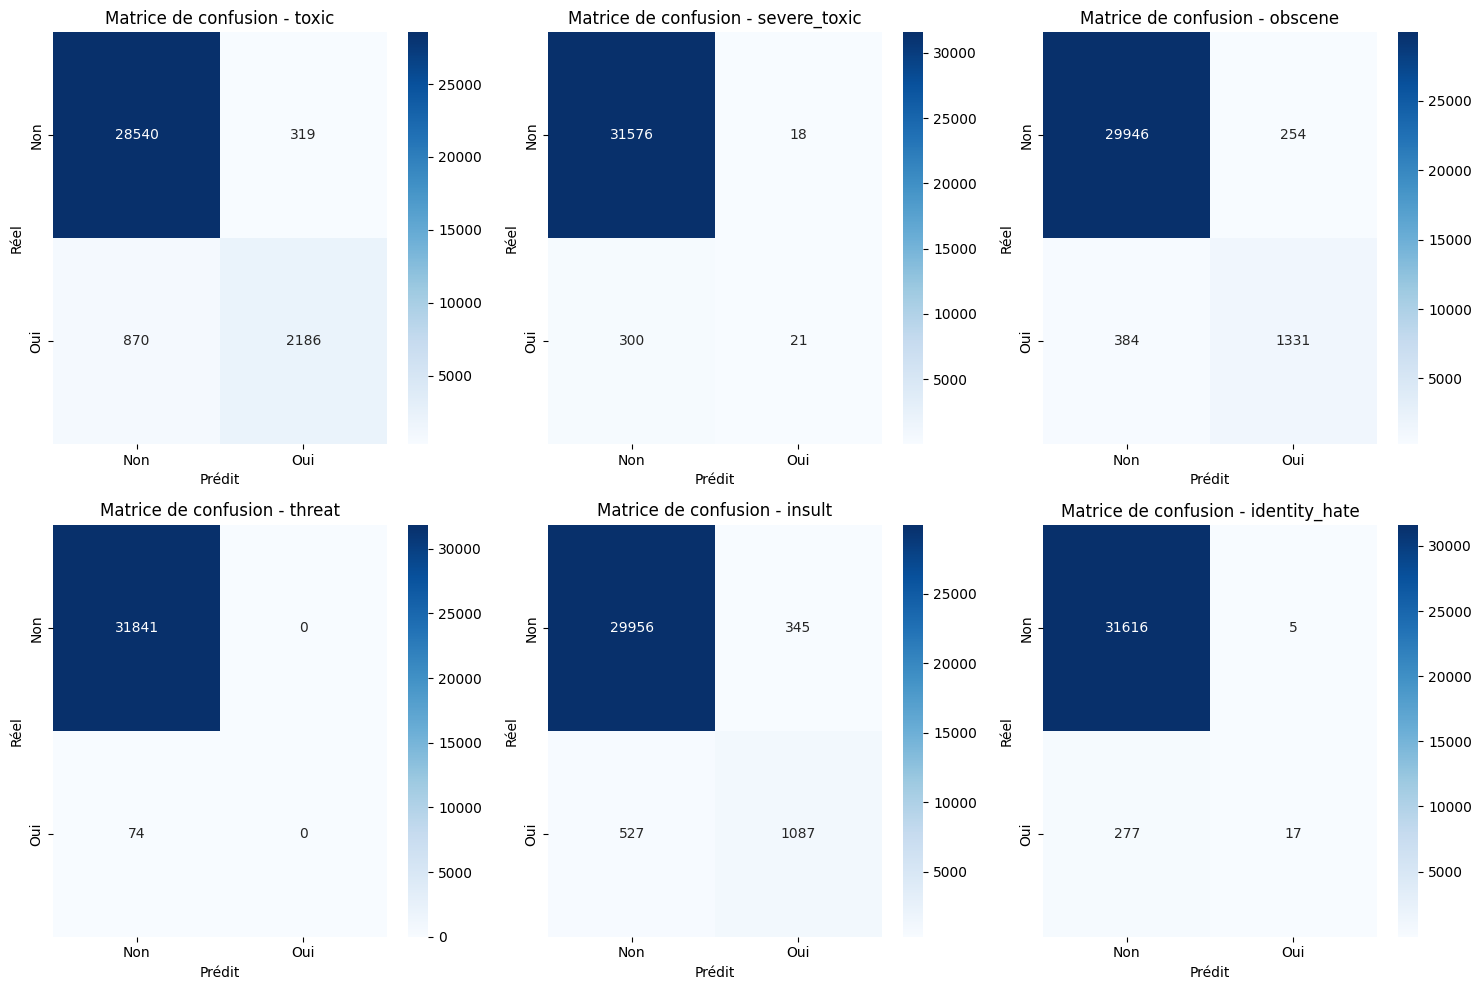

In [9]:
# F1-Score par classe
f1_scores = f1_score(y_test, y_pred, average=None)
for i, label in enumerate(label_names):
    print(f"F1-Score for {label}: {f1_scores[i]:.4f}")

# Score F1 global (moyenne macro)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"\nF1-Score Macro (moyenne des classes): {f1_macro:.4f}")

# 8. MATRICES DE CONFUSION
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, label in enumerate(label_names):
    cm = confusion_matrix(y_test[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non", "Oui"], yticklabels=["Non", "Oui"], ax=axes[i])
    axes[i].set_title(f"Matrice de confusion - {label}")
    axes[i].set_xlabel("Prédit")
    axes[i].set_ylabel("Réel")

plt.tight_layout()
plt.show()

In [14]:
# 1. Définir une fonction pour effectuer la prédiction
def predict_toxicity(text, tokenizer, model, label_names, max_len=100, threshold=0.5):
    # 1. Prétraitement du texte (tokenisation et padding)
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')

    # 2. Prédiction avec le modèle
    y_pred_proba = model.predict(padded_sequence)

    # 3. Appliquer un seuil (threshold) pour les prédictions binaires
    y_pred = (y_pred_proba > threshold).astype(int)

    # 4. Créer un dictionnaire avec les résultats
    prediction_results = {label: y_pred[0][i] for i, label in enumerate(label_names)}

    # Retourner les résultats
    return prediction_results

# Exemple d'utilisation avec un texte d'entrée
toxic_input = "You are a horrible person!"  # Exemple de texte d'entrée
predictions = predict_toxicity(toxic_input, tokenizer, model, label_names)

# Afficher les résultats des prédictions
print("Prédictions pour le texte :", input_text)
for label, pred in predictions.items():
    print(f"{label}: {'Oui' if pred == 1 else 'Non'}")



severe_toxic_input = "You are a fucking idiot, I hope you die, mother fucker!"
predictions = predict_toxicity(severe_toxic_input, tokenizer, model, label_names)

for label, pred in predictions.items():
    print(f"{label}: {'Oui' if pred == 1 else 'Non'}")


identity_hate_input = "People like you don't belong here, go back to your country. I hate people like you."
predictions = predict_toxicity(identity_hate_input, tokenizer, model, label_names)

for label, pred in predictions.items():
    print(f"{label}: {'Oui' if pred == 1 else 'Non'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Prédictions pour le texte : You are a horrible person!
toxic: Oui
severe_toxic: Non
obscene: Non
threat: Non
insult: Non
identity_hate: Non
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
toxic: Oui
severe_toxic: Non
obscene: Oui
threat: Non
insult: Oui
identity_hate: Non
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
toxic: Oui
severe_toxic: Non
obscene: Non
threat: Non
insult: Non
identity_hate: Non
